Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 148us/step - loss: 188.3774 - val_loss: 171.4411
Epoch 2/50
60000/60000 [==============================] - 7s 121us/step - loss: 169.4671 - val_loss: 167.8593
Epoch 3/50
60000/60000 [==============================] - 7s 122us/step - loss: 166.4715 - val_loss: 165.6819
Epoch 4/50
60000/60000 [==============================] - 7s 118us/step - loss: 164.2775 - val_loss: 163.6373
Epoch 5/50
60000/60000 [==============================] - 7s 120us/step - loss: 162.4680 - val_loss: 162.1045
Epoch 6/50
60000/60000 [==============================] - 7s 120us/step - loss: 160.8765 - val_loss: 160.2835
Epoch 7/50
60000/60000 [==============================] - 7s 122us/step - loss: 159.5790 - val_loss: 159.4710
Epoch 8/50
60000/60000 [==============================] - 7s 118us/step - loss: 158.4685 - val_loss: 158.1943
Epoch 9/50
60000/60000 [==============================] - 7s 117us/ste

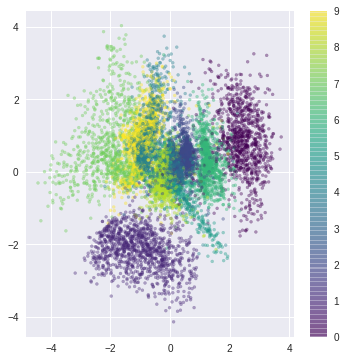

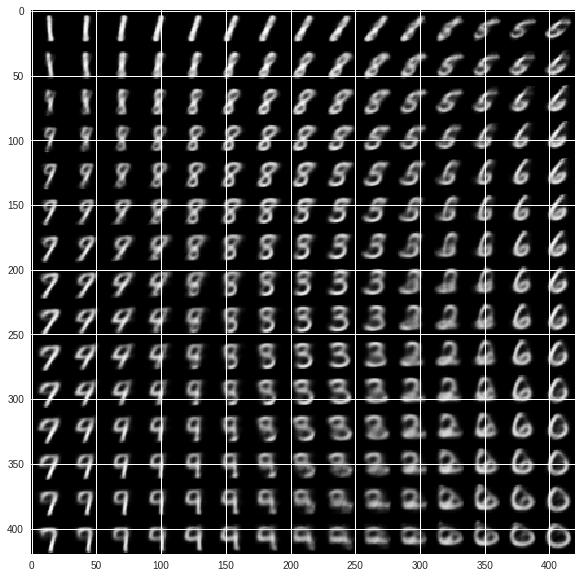

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()
